In [39]:
# all internal libraries
import pathlib
import time
import datetime
import io
import urllib
import tempfile

# dependencies
import shapely.geometry
import networkx as nx
import simpy
import numpy as np
import pandas as pd

# our software
import opentnsim.core

%matplotlib inline

In [40]:
# link to the latets version of the network
url = 'https://zenodo.org/record/3981105/files/network_digital_twin_v0.1.yaml'


In [41]:
# Reading network (might take a few minutes on a slow connection)

# Create a temporary file
f = tempfile.NamedTemporaryFile()
f.close()

urllib.request.urlretrieve(url, f.name)
G = nx.read_yaml(f.name)

# Making geometry really a geometry type
for n in G.nodes:
    G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    
del f

## Repeat for real case

In [42]:
# Creating a library of some interesting locations
def find_closest_node(G, point):
    """ Find the node on graph G that is closest to the given 
    shapely.geometry.Point point """
    distance = np.full((len(G.nodes)), fill_value=np.nan)
    for ii, n in enumerate(G.nodes):
        distance[ii] = point.distance(G.nodes[n]['geometry'])
    name_node = list(G.nodes)[np.argmin(distance)]
    distance_node = np.min(distance)
    return name_node, distance_node

# some interesting locations
locations = {
    'Transferium Maasvlakte': shapely.geometry.Point(4.087406, 51.936737),
    'Neusse': shapely.geometry.Point(6.708892, 51.215737),
    'Basel': shapely.geometry.Point(7.640572, 47.555449)
}

# find the closest nodes on the graph
locations_nodes = {n: find_closest_node(G, locations[n])[0] for n in locations}


In [43]:
# Find basic route
start_point = locations_nodes['Transferium Maasvlakte']
end_point = locations_nodes['Basel']
path = nx.dijkstra_path(G, start_point, end_point, weight='Length')

In [76]:
# define environment
env = simpy.Environment()

# set time for simulation
simulation_start = datetime.datetime(2018, 7, 1)
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = G

# quick check on the graph: do the edges have resources?
edge = env.FG.edges[8864523.0,8864358.0]
print(f'Edges have resources? {"Resources" in edge.keys()}')

Edges have resources? False


In [45]:
# Make a transport resource class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable), {})

# For testing purposes we only want v to be 1, whether empty or loaded
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

# Define vessel data, but do not yet link to env or route
data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": G.nodes[start_point]['geometry'],  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}


In [46]:
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Log, opentnsim.core.Locatable, opentnsim.core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": G.nodes[start_point]['geometry']}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": G.nodes[end_point]['geometry']}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)

nodes = [node_1, node_2]


In [49]:
# create the transport processing resource
vessel1 = TransportResource(**data_vessel)

# Add the vessel to the environment, and define the start and end point
vessel1.env = env
vessel1.start_loc = start_point
vessel1.end_loc = end_point

# also define its current location as the start point for now
vessel1.current_loc = start_point

# add the route
vessel1.route = path

# check route
#vessel1.route

In [50]:
# create the transport processing resource
vessel2 = TransportResource(**data_vessel)

# Add the vessel to the environment, and define the start and end point
vessel2.env = env
vessel2.start_loc = start_point
vessel2.end_loc = end_point

# also define its current location as the start point for now
vessel2.current_loc = start_point

#--> seems as though this path is sailed even though it is updated on the while loop of the start function

# add the route (is it needed to add it as an empty list?)
#vessel2.route = []

# check route
#vessel2.route

In [51]:
# simply move a vessel accross a predefined route
def start(env, vessel):
    yield from vessel.move()
    

In [52]:
# function to sail vessel with route decision
def start_dynamic(env, vessel):
    """ Have a vessel sail from start_point to end_point, while after every
    egde passed checking if the current route is still available"""
    # while vessel.location is not end_location
    # bepaal de kortste route van huidige locatie naar eindpunt
    # neem eerste edge uit deze route en zet deze als route in de vessel
    # move vessel over deze 'route'
    # ergens daartussen: if t>100 zet een edge op de nog te volgen route op weight 999999
    # schip moet nu een alternatieve route kiezen
    while vessel.current_loc != vessel.end_loc:
        # determine the shortest path from the current to the end location
        shortest_path = nx.dijkstra_path(G, vessel.current_loc, vessel.end_loc, weight='Length')
        # make sure the vessel passes only the first edge in the route
        vessel.route = [shortest_path[0], shortest_path[1]]
        # make sure the current location is now updated
        vessel.current_loc = shortest_path[1]
        yield from vessel.move()


In [53]:
# add the processes and run the environments
env.process(start(env, vessel1))
env.process(start_dynamic(env, vessel2))
env.run()

In [55]:
# check the log of vessel 1
df1 = pd.DataFrame.from_dict(vessel1.log)
df1.head(6).append(df1.tail(6))

,Message,Timestamp,Value,Geometry
0,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:00:00.000000,0,POINT (4.08441957198572 51.9376698026918)
1,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
2,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
3,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:05:40.134353,0,POINT (4.08419044915029 51.9398020492115)
4,Sailing from node 8863826.0 to node 8861217.0 ...,2018-07-01 00:05:40.134353,0,POINT (4.08419044915029 51.9398020492115)
311,Sailing from node L1291004_A to node L1282583_...,2018-07-09 05:26:10.683577,0,POINT (7.525972546373181 47.65249561253358)
312,Sailing from node L1282583_B to node L1282583_...,2018-07-09 05:26:10.683577,0,POINT (7.525972546373181 47.65249561253358)
313,Sailing from node L1282583_B to node L1282583_...,2018-07-09 05:26:50.479620,0,POINT (7.526214770586178 47.65217729283479)
314,Sailing from node L1282583_A to node FN16 start,2018-07-09 05:26:50.479620,0,POINT (7.526214770586178 47.65217729283479)
315,Sailing from node L1282583_A to node FN16 stop,2018-07-09 08:06:40.148480,0,POINT (7.584361254015838 47.57540886152157)


In [57]:
# check the log of vessel 2
df2 = pd.DataFrame.from_dict(vessel2.log)
df2.head(6).append(df2.tail(6))

,Message,Timestamp,Value,Geometry
0,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:00:00.000000,0,POINT (4.08441957198572 51.9376698026918)
1,Sailing from node 22161408.0 to node 22161426....,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
2,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:03:48.775496,0,POINT (4.08575840028067 51.9395520396609)
3,Sailing from node 22161426.0 to node 8863826.0...,2018-07-01 00:05:40.134353,0,POINT (4.08419044915029 51.9398020492115)
4,Sailing from node 8863826.0 to node 8861217.0 ...,2018-07-01 00:05:40.134353,0,POINT (4.08419044915029 51.9398020492115)
5,Sailing from node 8863826.0 to node 8861217.0 ...,2018-07-01 00:13:00.370939,0,POINT (4.07845167182249 51.94155542604053)
310,Sailing from node L1291004_A to node L1282583_...,2018-07-09 01:51:22.732756,0,POINT (7.526428831640564 47.76841000341269)
311,Sailing from node L1291004_A to node L1282583_...,2018-07-09 05:26:10.683577,0,POINT (7.525972546373181 47.65249561253358)
312,Sailing from node L1282583_B to node L1282583_...,2018-07-09 05:26:10.683577,0,POINT (7.525972546373181 47.65249561253358)
313,Sailing from node L1282583_B to node L1282583_...,2018-07-09 05:26:50.479620,0,POINT (7.526214770586178 47.65217729283479)


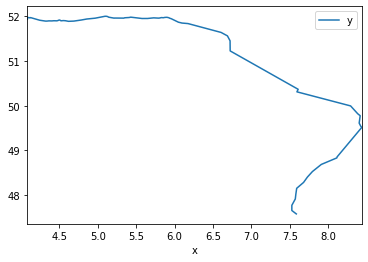

In [58]:
# get log and plot track of vessel 1
df1['x'] = df.Geometry.apply(lambda geom: geom.x)
df1['y'] = df.Geometry.apply(lambda geom: geom.y)
df1.plot('x', 'y')

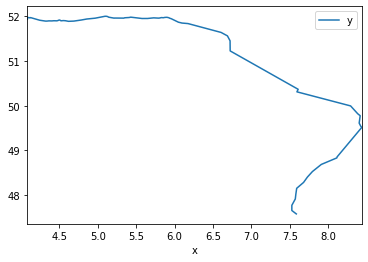

In [59]:
# get log and plot track of vessel 2
df2['x'] = df.Geometry.apply(lambda geom: geom.x)
df2['y'] = df.Geometry.apply(lambda geom: geom.y)
df2.plot('x', 'y')